# System Identification - NARMAX

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + v \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
v     =&\ \text{viscous damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
e(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, with the parameter $\tau$ representing the precision of the process. Measurement noise is also Wiener, with $\gamma$ as precision.

### Forecasting experiment

In this notebook, we will perform a forecasting experiment. The time-series will be split into a training and a validation part. In the training part, we will provide both input and output, and then infer parameters. In the forecasting part, we will only provide input. The parameters will be fixed to their inferred values and we will let the model make predictions for the output. Those predictions are evaluated against the true output.

### Data

Let's first have a look at the data.

In [1]:
using CSV
using DataFrames

In [2]:
using Plots
viz = false;

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
# Select training set
ix_trn = collect(40101:131072)
# ix_trn = collect(40101:50100)
input_trn = input[ix_trn]
output_trn = output[ix_trn]
T_trn = length(ix_trn);

# Select validation set
ix_val = 101:40100
input_val = input[ix_val]
output_val = output[ix_val]
T_val = length(ix_val);

In [5]:
# Plot every n-th time-point to avoid figure size exploding
n = 100

if viz
    p1a = Plots.plot(1:n:T_trn, input_trn[1:n:end], color="black", label="", markersize=2, xlabel="", ylabel="input", size=(1200,400), title="training")    
    p1b = Plots.plot(1:n:T_trn, output_trn[1:n:end], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output", size=(1200,400))    
    p1 = plot(p1a, p1b, layout=(2,1))
#     Plots.savefig(p1, "viz/training_set.png")
end

In [6]:
if viz
    p2a = Plots.plot(1:n:T_val, input_val[1:n:end], color="black", label="", markersize=2, xlabel="", ylabel="input", size=(1200,400), title="validation")    
    p2b = Plots.plot(1:n:T_val, output_val[1:n:end], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output", size=(1200,400))    
    p2 = plot(p2a, p2b, layout=(2,1))
#     Plots.savefig(p2, "viz/validation_set.png")
end

## Solution steps

In this notebook we are tackling the system with a black-box model, ignoring the physical parameters altogether.

### 1. NARMAX model

NARMAX stands for **n**onlinear **a**uto**r**egressive **m**oving **a**verage model with e**x**ogenous inputs. It sports the following function:

$$\begin{align}
y_k =&\ f(y_{k-1}, \dots, y_{k-n_x}, u_k, u_{k-1}, \dots, u_{k-n_z}, e_{k-1}, \dots, e_{k-n_r})  + e_k
\end{align}$$

where $n_x$ is the number of previous observations, $n_z$ the number of previous inputs and $n_r$ the number of previous errors under consideration. The error term $e_k$ is assumed to follow white noise: $e_k \sim \mathcal{N}(0, \tau^{-1})$.

I'm going to concatenate terms into a vector as follows:
$$\begin{align*}
x_{k-1} = \begin{bmatrix} y_{k-1} \\ \vdots \\ y_{t-n_x} \end{bmatrix} \, , \quad 
z_{k-1} = \begin{bmatrix} u_{k-1} \\ \vdots \\ u_{t-n_z} \end{bmatrix} \, , \quad 
r_{k-1} = \begin{bmatrix} e_{k-1} \\ \vdots \\ e_{t-n_r} \end{bmatrix} \, .
\end{align*}$$

Plugging these in, I get the following shorter function:

$$\begin{align}
y_k =&\ f(\theta, x_{k-1}, u_k, z_{k-1}, r_{k-1})  + e_k
\end{align}$$

The function is parameterized by $\theta$, which is included as an input argument.


### 2. Convert to Gaussian probability

Integrating out $e_k$ produces a Gaussian node:

$$y_k \sim \mathcal{N}(f(\theta, x_{k-1}, u_k, z_{k-1}, r_{k-1}), \tau^{-1}) \, .$$

We can approximate the nonlinearity $f$ around $\theta$ through a Taylor series:

$$f(\theta, x_{k-1}, u_k, z_{k-1}, r_{k-1}) \approx f(m_\theta, x_{k-1}, u_k, z_{k-1}, r_{k-1}) + J_{\theta}^{\top}(\theta - m_{\theta})$$

where $J_{\theta} = \frac{d f}{d \theta} \big\vert_{\theta = m_{\theta}}$. The Jacobian can be obtained automatically using Julia packages such as [Zygote.jl](https://github.com/FluxML/Zygote.jl). 

The above is a likelihood node. The state transitions are deterministic and consist of just updating the history vectors $x_k = S_{y}x_{k-1} + s_{y}y_k$, $z_k = S_{u}z_{k-1} + s_{u}u_k$, and $r_k = S_{e} r_{k-1} + s_{e} e_k$ where:

$$ S_{y} = \begin{bmatrix} 0 & \dots & 0 \\ & & \\ I_{n_x-1} & & 0 \end{bmatrix} \, , \quad s_{y} = \begin{bmatrix} 1 \\ 0_1 \\ \vdots \\ 0_{n_x-1}\end{bmatrix}$$

and likewise for the other $S$ and $s$'s.

### 3. Choose priors

We currently have unknown parameters $\theta$ and $\tau$. The coeffients can be both positive and negative, so we will opt for a Gaussian prior. The prior for a precision parameter $\tau$ will be a Gamma distribution.

$$\begin{align}
p(\theta) =&\ \text{Normal}(\theta \mid m^{0}_{\theta}, V^{0}_{\theta}) \\
p(\tau) =&\ \text{Gamma}(\tau \mid a^{0}_\tau, b^{0}_\tau) \, .
\end{align}$$

### 4. Recognition model

We choose the simplest possible recognition model, a mean-field factorisation of both unknown variables:

$$\begin{align}
q(\theta) =&\ \text{Normal}(\theta \mid m_{\theta}, V_{\theta}) \\
q(\tau) =&\ \text{Gamma}(\tau \mid a_\tau, b_\tau) \, .
\end{align}$$

Note that the generative and recognition model match, which means the KL-divergence between the generative and recognition model can potentially be driven to $0$.

## Implementation

We implement this model with the toolbox ForneyLab.jl and a custom NARMAX node.

In [7]:
using ProgressMeter
using LinearAlgebra
using ForneyLab

import MultivariatePolynomials: monomials, subs
import TypedPolynomials: @polyvar
import ForneyLab: unsafeMean

In [8]:
using NARMAX

In [9]:
# Start graph
graph = FactorGraph()

# Autoregression orders
n_x = 2
n_z = 2
n_r = 2
n_k = n_x + n_z + n_r + 1

# Nonlinearity
n_d = 3
@polyvar ξ[1:7]
ϕ(x::Array{Float64,1}) = subs(monomials(ξ, [0,1,2,3]), ξ => x)

# Number of parameters
num_coeffs = sum([binomial(deg + n_k-1, deg) for deg in 0:n_d])

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(num_coeffs,)), placeholder(:W_θ, dims=(num_coeffs, num_coeffs)))
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# Setup observation and input vectors
@RV u_k
@RV x_kmin1
@RV z_kmin1
@RV r_kmin1

# NARMAX node
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, x_kmin1, u_k, z_kmin1, r_kmin1, τ, g=ϕ)

# Mark placeholders for observation
placeholder(y_k, :y_k)
placeholder(x_kmin1, :x_kmin1, dims=(n_x,))
placeholder(z_kmin1, :z_kmin1, dims=(n_z,))
placeholder(r_kmin1, :r_kmin1, dims=(n_r,))
placeholder(u_k, :u_k)

# Draw time-slice subgraph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 13286875483594639362 -->
 
 13286875483594639362 
 
 placeholder_x_kmin1 
 
<!-- 3729833885907890011 -->
 
 3729833885907890011 
 
 NARMAX 
 nautoregressivemovingaveragex_1 
 
<!-- 13286875483594639362--3729833885907890011 -->
 
 13286875483594639362--3729833885907890011 
 
 x_kmin1 
 3 x 
 1 out 
 
<!-- 8052742708189110929 -->
 
 8052742708189110929 
 
 placeholder_r_kmin1 
 
<!-- 8052742708189110929--3729833885907890011 -->
 
 8052742708189110929--3729833885907890011 
 
 r_kmin1 
 6 r 
 1 out 
 
<!-- 4518664910395337129 -->
 
 4518664910395337129 
 
 placeholder_y_k 
 
<!-- 4518664910395337129--3729833885907890011 -->
 
 4518664910395337129--3729833885907890011 
 
 y_k 
 1 y 
 1 out 
 
<!-- 12274593324731304261 -->
 
 12274593324731304261 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 10202839857672341515 -->
 
 10202839857672341515 
 
 placeholder_m_θ 
 
<!-- 12274593324731304261--10202839857672341515 -->
 
 12274593324731304261--10202839857672341515 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 1581111315260407981 -->
 
 1581111315260407981 
 
 placeholder_W_θ 
 
<!-- 12274593324731304261--1581111315260407981 -->
 
 12274593324731304261--1581111315260407981 
 
 W_θ 
 1 out 
 3 w 
 
<!-- 3729833885907890011--12274593324731304261 -->
 
 3729833885907890011--12274593324731304261 
 
 θ 
 1 out 
 2 θ 
 
<!-- 5308522674215595456 -->
 
 5308522674215595456 
 
 Gam 
 gamma_1 
 
<!-- 3729833885907890011--5308522674215595456 -->
 
 3729833885907890011--5308522674215595456 
 
 τ 
 1 out 
 7 τ 
 
<!-- 1597572763148683016 -->
 
 1597572763148683016 
 
 placeholder_b_τ 
 
<!-- 6805614585024688114 -->
 
 6805614585024688114 
 
 placeholder_z_kmin1 
 
<!-- 6805614585024688114--3729833885907890011 -->
 
 6805614585024688114--3729833885907890011 
 
 z_kmin1 
 5 z 
 1 out 
 
<!-- 14640186644457537783 -->
 
 14640186644457537783 
 
 placeholder_a_τ 
 
<!-- 18184689451013403578 -->
 
 18184689451013403578 
 
 placeholder_u_k 
 
<!-- 18184689451013403578--3729833885907890011 -->
 
 18184689451013403578--3729833885907890011 
 
 u_k 
 4 u 
 1 out 
 
<!-- 5308522674215595456--1597572763148683016 -->
 
 5308522674215595456--1597572763148683016 
 
 b_τ 
 1 out 
 3 b 
 
<!-- 5308522674215595456--14640186644457537783 -->
 
 5308522674215595456--14640186644457537783 
 
 a_τ 
 1 out 
 2 a

In [10]:
# Define variational message passing procedure
q = PosteriorFactorization(θ, τ, ids=[:θ, :τ])
algo = messagePassingAlgorithm(free_energy=false)

# Compile and import compiled functions
source_code = algorithmSourceCode(algo, free_energy=false)
eval(Meta.parse(source_code));
# println(source_code)

### Infer parameters

In [11]:
# Inference parameters
num_iterations = 5

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_θ = (ones(num_coeffs, T_trn+1), repeat(.1 .*float(eye(num_coeffs)), outer=(1,1, T_trn+1)))
params_τ = (1. *ones(1, T_trn+1), 1. *ones(1, T_trn+1))

predictions = zeros(T_trn+1,)
residuals = zeros(n_r, T_trn+1)

@showprogress for k = maximum([n_x, n_z, n_r])+1:T_trn

    # Initialize marginals
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,k], w=params_θ[2][:,:,k])
    marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=params_τ[1][1,k], b=params_τ[2][1,k])
    
    # Compute residuals
    residuals[:,k] = output[k-1:-1:k-n_r] .- predictions[k-1:-1:k-n_r]

    # Update observed data
    data = Dict(:y_k => output_trn[k],
                :u_k => input_trn[k],
                :x_kmin1 => output_trn[k-1:-1:k-n_x],
                :z_kmin1 => input_trn[k-1:-1:k-n_z],
                :r_kmin1 => residuals[:,k],
                :m_θ => params_θ[1][:,k],
                :W_θ => params_θ[2][:,:,k],
                :a_τ => params_τ[1][1,k],
                :b_τ => params_τ[2][1,k])

    for i = 1:num_iterations
        
        # Update precision
        stepτ!(data, marginals)

        # Update coefficients
        stepθ!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_θ[1][:,k+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,k+1] = marginals[:θ].params[:w]
    params_τ[1][1,k+1] = marginals[:τ].params[:a]
    params_τ[2][1,k+1] = marginals[:τ].params[:b]
    
    # Update predictions
    predictions[k] = params_θ[1][:,k+1]'*ϕ([output[k-1:-1:k-n_x]; input[k]; input[k-1:-1:k-n_z]; residuals[:,k]])

end

Progress: 100%|█████████████████████████████████████████| Time: 0:54:13m12m


In [12]:
using JLD
save("params_NARMAXpol3.jld", "params_θ", "params_τ")

In [13]:
# Number of params to visualize
nviz = 8

# Extract parameters of final coefficients for the history of observations
mθ_x = zeros(T_trn, nviz)
sθ_x = zeros(T_trn, nviz)
for k = 1:nviz
    mθ_x[:,k] = params_θ[1][k, 2:end]
    sθ_x[:,k] = sqrt.(inv.(params_θ[2][k,k, 2:end]))
end

# Labels
labels = ["θ_"*string(k) for i=1:1, k=1:nviz]

if viz
    # Plot every n-th time-point to avoid figure size exploding
    n = 50
    
    # Plot evolution of coefficients
    p5 = Plots.plot(1:n:T_trn, 
                    mθ_x[1:n:T_trn,:], 
                    ribbon=[sθ_x[1:n:T_trn,:], sθ_x[1:n:T_trn,:]], 
                    linewidth=3, 
                    label=labels, 
                    xlabel="time (t)", 
                    ylabel="Parameter estimate", 
                    title="First "*string(nviz)*" parameters",
#                     xscale=:log10,
#                     ylims=[-2.2, 4.8],
                    legend=:topright)
end

In [14]:
# Extract parameters of final precision posteriors
mτ = params_τ[1][1,2:end] ./ params_τ[2][1,2:end]
sτ = sqrt.(params_τ[1][1,2:end] ./ params_τ[2][1,2:end].^2)

if viz
    # Plot evolution of precision parameter
    p8 = plot(1:n:T_trn, 
              mτ[1:n:T_trn], 
#               ribbon=[sτ[1:n:T_trn], sτ[1:n:T_trn]], 
              label="τ", 
              xlabel="time (t)", 
              linewidth=3, 
              yscale=:log10,
              size=(600,400), 
              legend=:topleft)
end

## 1-step ahead prediction error

In [15]:
# Start graph
graph2 = FactorGraph()

# Clamped variables
@RV x_kmin1
@RV z_kmin1
@RV r_kmin1
@RV u_k
@RV θ
@RV τ

# Autoregressive node
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, x_kmin1, u_k, z_kmin1, r_kmin1, τ, g=ϕ)

# Indicate observed variables
placeholder(θ, :θ, dims=(num_coeffs,))
placeholder(x_kmin1, :x_kmin1, dims=(n_x,))
placeholder(z_kmin1, :z_kmin1, dims=(n_z,))
placeholder(r_kmin1, :r_kmin1, dims=(n_r,))
placeholder(u_k, :u_k)
placeholder(τ, :τ)

# Draw time-slice subgraph
# ForneyLab.draw(graph2)

# Inference algorithm
q2 = PosteriorFactorization(y_k, ids=[:y_k])
algo2 = messagePassingAlgorithm(free_energy=false)
source_code2 = algorithmSourceCode(algo2, free_energy=false)
eval(Meta.parse(source_code2));
# println(source_code2);

In [16]:
# Fix estimates of coefficients and precision
mθ = params_θ[1][:,end]
mτ = params_τ[1][1,end]/params_τ[2][1,end]

# Initialize arrays of parameterizations
params_y = (zeros(1,T_val), zeros(1,T_val))

predictions = zeros(T_val+1,)
residuals = zeros(n_r, T_val+1)

# Perform inference at each time-step
@showprogress for k = maximum([n_x, n_z, n_r])+1:T_val

    # Initialize marginals
    marginals[:y_k] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_y[1][:,k-1], w=params_y[2][1,k-1])
    
    # Compute residuals
    residuals[:,k] = output_val[k-1:-1:k-n_r] .- params_y[1][1,k-1:-1:k-n_r]
    
    # Set clamped variables
    data = Dict(:u_k => input_val[k],
                :x_kmin1 => output_val[k-1:-1:k-n_x],
                :z_kmin1 => input_val[k-1:-1:k-n_z],
                :r_kmin1 => residuals[:,k],
                :θ => mθ,
                :τ => mτ)
        
    # Update output prediction
    stepy_k!(data, marginals)

    # Store current parameterizations of marginals
    params_y[1][1,k] = unsafeMean(marginals[:y_k])
    params_y[2][1,k] = marginals[:y_k].params[:w]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


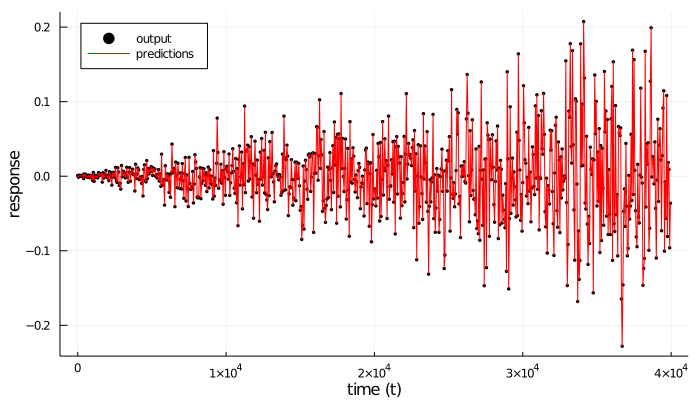

In [17]:
# Plot every n-th time-point to avoid figure size exploding
n = 50

predictions = params_y[1][1,:]

p3a = Plots.scatter(1:n:T_val, output_val[1:n:T_val], color="black", label="output", markersize=2, xlabel="time (t)", ylabel="response", legend=:topleft)
Plots.plot!(1:n:T_val, predictions[1:n:T_val], color="red", linewidth=1, label="predictions", size=(700,400))

In [18]:
savefig(p3a, "figures/FEM_NARMAXpol3_pred-forecasts.png")

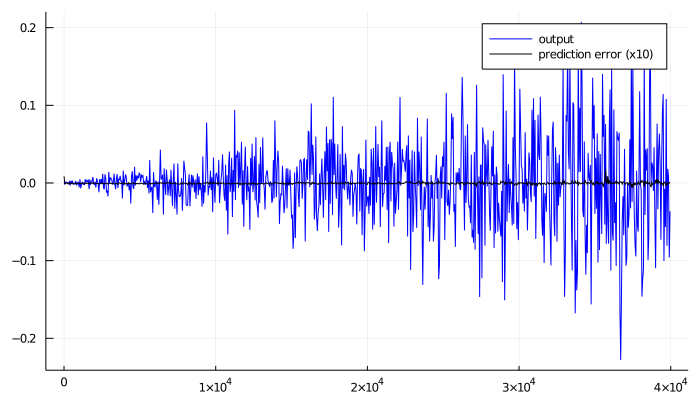

In [19]:
predictions = params_y[1][1,:]
error = output_val .- predictions

# p3b = plot(1:n:T_val, predictions[1:n:T_val], color="purple", linewidth=1, label="predictions", size=(700,400))
p3b = plot(1:n:T_val, output_val[1:n:T_val], color="blue", linewidth=1, label="output", size=(700,400))
plot!(1:n:T_val, 10 .*error[1:n:T_val], color="black", linewidth=1, label="prediction error (x10)", size=(700,400))

In [20]:
Plots.savefig(p3b, "figures/FEM_NARMAXpol3_pred-comparison.png")

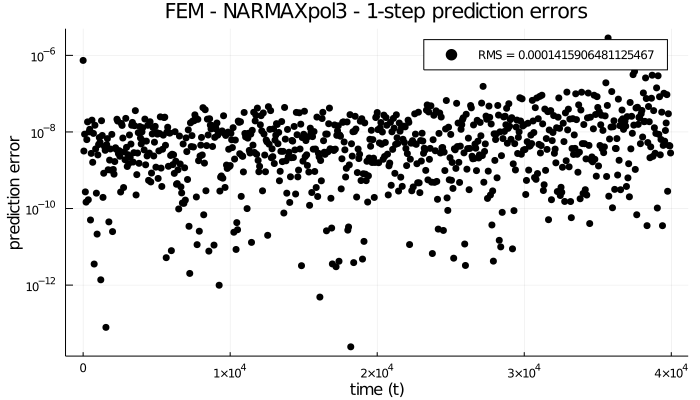

In [21]:
# Error plot
sq_pred_error_FEM = (predictions .- output_val).^2
p4 = scatter(1:n:T_val, 
             sq_pred_error_FEM[1:n:T_val], 
             color="black", 
             markersize=4, 
             size=(700,400), 
             xlabel="time (t)", 
             ylabel="prediction error",
             labels="RMS = "*string(sqrt(mean(sq_pred_error_FEM))),
             yscale=:log10,
             title="FEM - NARMAXpol3 - 1-step prediction errors")

In [22]:
Plots.savefig(p4, "figures/FEM_NARMAXpol3_pred-errors.png")

## Simulation error on validation data

In [23]:
# Start graph
graph2 = FactorGraph()

# Clamped variables
@RV x_kmin1
@RV z_kmin1
@RV r_kmin1
@RV u_k
@RV θ
@RV τ

# Autoregressive node
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, x_kmin1, u_k, z_kmin1, r_kmin1, τ, g=ϕ)

# Indicate observed variables
placeholder(θ, :θ, dims=(num_coeffs,))
placeholder(x_kmin1, :x_kmin1, dims=(n_x,))
placeholder(z_kmin1, :z_kmin1, dims=(n_z,))
placeholder(r_kmin1, :r_kmin1, dims=(n_r,))
placeholder(u_k, :u_k)
placeholder(τ, :τ)

# Draw time-slice subgraph
# ForneyLab.draw(graph2)

# Inference algorithm
q2 = PosteriorFactorization(y_k, ids=[:y_k])
algo2 = messagePassingAlgorithm(free_energy=false)
source_code2 = algorithmSourceCode(algo2, free_energy=false)
eval(Meta.parse(source_code2));
# println(source_code2);

In [24]:
# Fix estimates of coefficients and precision
mθ = params_θ[1][:,end]
mτ = params_τ[1][1,end]/params_τ[2][1,end]

# Initialize arrays of parameterizations
params_y = (zeros(1,T_val), zeros(1,T_val))

predictions = zeros(T_val+1,)
residuals = zeros(n_r, T_val+1)

# Perform inference at each time-step
@showprogress for k = maximum([n_x, n_z, n_r])+1:T_val

    # Initialize marginals
    marginals[:y_k] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_y[1][:,k-1], w=params_y[2][1,k-1])
    
    # Compute residuals
    residuals[:,k] = zeros(n_r,)
    
    # Set clamped variables
    data = Dict(:u_k => input_val[k],
                :x_kmin1 => output_val[k-1:-1:k-n_x],
                :z_kmin1 => input_val[k-1:-1:k-n_z],
                :r_kmin1 => residuals[:,k],
                :θ => mθ,
                :τ => mτ)
        
    # Update output prediction
    stepy_k!(data, marginals)

    # Store current parameterizations of marginals
    params_y[1][1,k] = unsafeMean(marginals[:y_k])
    params_y[2][1,k] = marginals[:y_k].params[:w]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


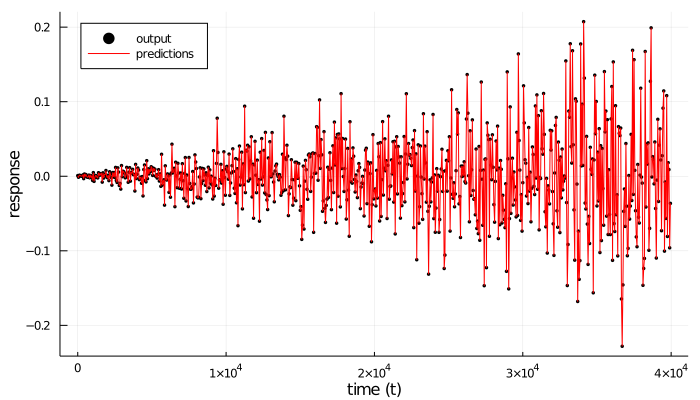

In [25]:
predictions = params_y[1][1,:]

p6 = scatter(1:n:T_val, output_val[1:n:T_val], color="black", label="output", markersize=2, xlabel="time (t)", ylabel="response", legend=:topleft)
plot!(1:n:T_val, predictions[1:n:T_val], color="red", linewidth=1, label="predictions", size=(700,400))

In [26]:
savefig(p6, "figures/FEM-NARMAXpol3-sim-forecast.png")

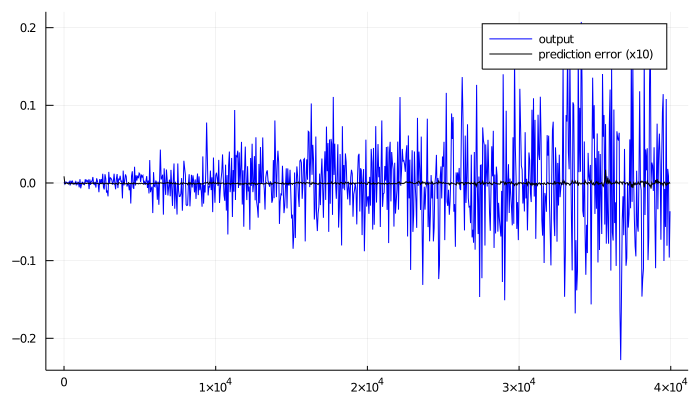

In [27]:
predictions = params_y[1][1,:]
error = output_val .- predictions

# p7 = plot(1:n:T_val, predictions[1:n:T_val], color="purple", linewidth=1, label="predictions", size=(700,400))
p7 = plot(1:n:T_val, output_val[1:n:T_val], color="blue", linewidth=1, label="output", size=(700,400))
plot!(1:n:T_val, 10 .*error[1:n:T_val], color="black", linewidth=1, label="prediction error (x10)", size=(700,400))

In [28]:
savefig(p7, "figures/FEM-NARMAXpol3-sim-comparison.png")

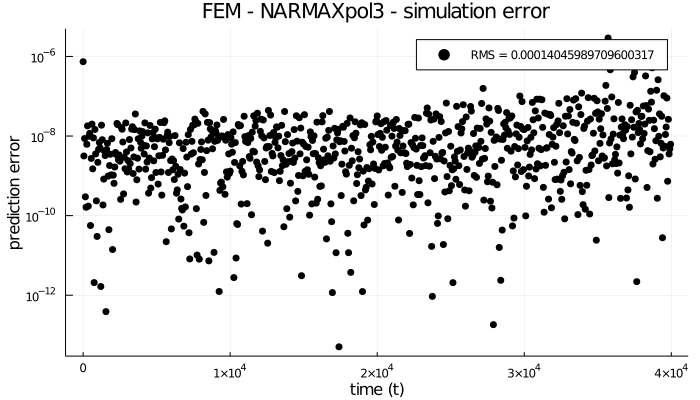

In [29]:
# Error plot
sq_sim_error_FEM = (predictions .- output_val).^2
p8 = scatter(1:n:T_val, 
             sq_sim_error_FEM[1:n:T_val], 
             color="black", 
             markersize=4, 
             size=(700,400), 
             xlabel="time (t)", 
             ylabel="prediction error",
             labels="RMS = "*string(sqrt(mean(sq_sim_error_FEM))),
             yscale=:log10,
             title="FEM - NARMAXpol3 - simulation error")

In [30]:
savefig(p8, "figures/FEM_NARMAXpol3_sim-errors.png")

### Baseline: NARMAXpol3-PEM

Maarten Schoukens has implemented a NARMAX model using least squares minimization for a polynomial basis expansion of order 3.

In [31]:
using MAT
results = matread("../sota-baselines/NARXpol3-PEM.mat")

Dict{String,Any} with 11 entries:
  "na"       => 2.0
  "model"    => Dict{String,Any}("na"=>2.0,"theta"=>[-0.00251839; 0.0490083; … …
  "ySim"     => [-0.00223554; -0.00334684; … ; -0.00583284; -0.00717056]
  "yTot"     => [0.0093978 0.012971 … -0.00605201 -0.00722471]
  "nd"       => 3.0
  "RMS_sim"  => 0.000638965
  "fs"       => 610.35
  "yPred"    => [-0.00223554; 0.0138126; … ; -0.0061052; -0.00727883]
  "RMS_pred" => 0.000114318
  "options"  => Dict{String,Any}("nd"=>3.0,"na"=>2.0,"nb"=>2.0)
  "nb"       => 2.0

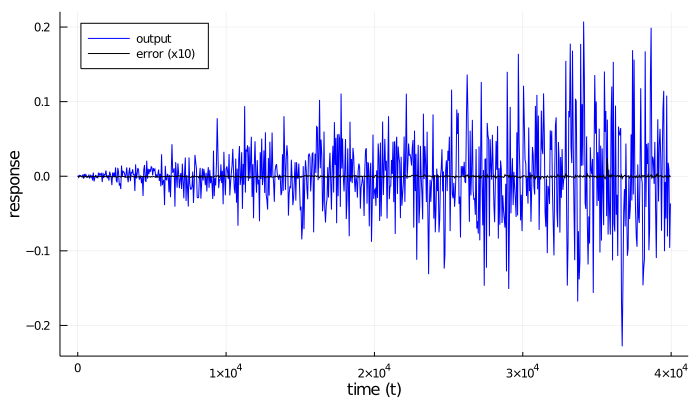

In [32]:
# Extract mean of state marginals
error = output[ix_val] .- results["yPred"][ix_val]

p14 = plot(1:n:T_val, output_val[1:n:T_val], color="blue", label="output", markersize=2, xlabel="time (t)", ylabel="response", legend=:topleft)
plot!(1:n:T_val, 10 .*error[1:n:T_val], color="black", linewidth=1, label="error (x10)", size=(700,400))

In [33]:
savefig(p14, "figures/PEM_NARMAXpol3_pred-forecasts.png")

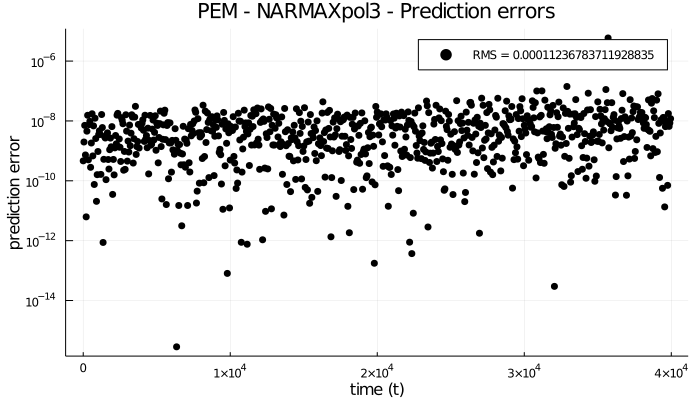

In [34]:
# Error plot
sq_pred_error_PEM = (output[ix_val] .- results["yPred"][ix_val]).^2
p15 = scatter(1:n:T_val, 
              sq_pred_error_PEM[1:n:T_val], 
              color="black", 
              markersize=4, 
              size=(700,400), 
              yscale=:log10,
              xlabel="time (t)", 
              ylabel="prediction error",
              labels="RMS = "*string(sqrt(mean(sq_pred_error_PEM))),
              title="PEM - NARMAXpol3 - Prediction errors")

In [35]:
savefig(p15, "figures/PEM_NARMAXpol3_pred-error.png")

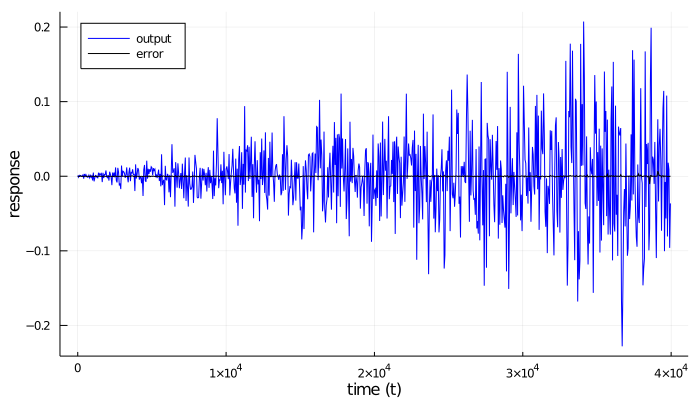

In [36]:
error = output[ix_val] .- results["ySim"][ix_val]

p16 = plot(1:n:T_val, output_val[1:n:T_val], color="blue", label="output", xlabel="time (t)", ylabel="response", legend=:topleft)
plot!(1:n:T_val, error[1:n:T_val], color="black", linewidth=1, label="error", size=(700,400))

In [37]:
savefig(p16, "figures/PEM_NARMAXpol3_sim-forecasts.png")

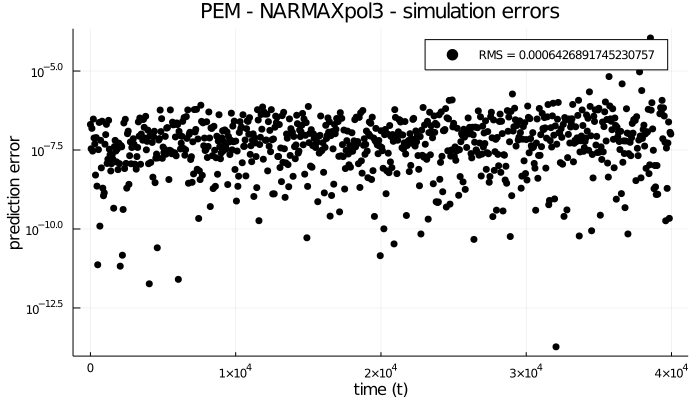

In [38]:
# Error plot
sq_sim_error_PEM = (output[ix_val] .- results["ySim"][ix_val]).^2
p17 = scatter(1:n:T_val, 
              sq_sim_error_PEM[1:n:T_val], 
              color="black", 
              markersize=4, 
              size=(700,400), 
              yscale=:log10,
              xlabel="time (t)", 
              ylabel="prediction error",
              labels="RMS = "*string(sqrt(mean(sq_sim_error_PEM[3:n:T_val]))),
              title="PEM - NARMAXpol3 - simulation errors")

In [39]:
savefig(p17, "figures/PEM_NARMAXpol3_sim-error.png")

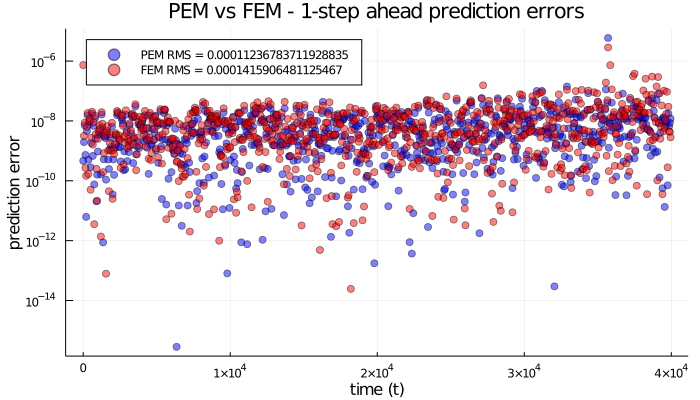

In [40]:
# Comparing 1-step ahead prediction errors between PEM and FEM
p18 = scatter(1:n:T_val, 
              sq_pred_error_PEM[1:n:T_val], 
              color="blue", 
              alpha=0.5,
              markersize=4, 
              size=(700,400), 
              yscale=:log10,
              xlabel="time (t)", 
              ylabel="prediction error",
              label="PEM RMS = "*string(sqrt(mean(sq_pred_error_PEM))),
              legend=:topleft)
scatter!(1:n:T_val, 
         sq_pred_error_FEM[1:n:T_val], 
         color="red", 
         alpha=0.5,
         markersize=4,
         labels="FEM RMS = "*string(sqrt(mean(sq_pred_error_FEM))),
         title="PEM vs FEM - 1-step ahead prediction errors")

In [41]:
savefig(p18, "figures/PEMvFEM_NARMAXpol3_pred-error.png")

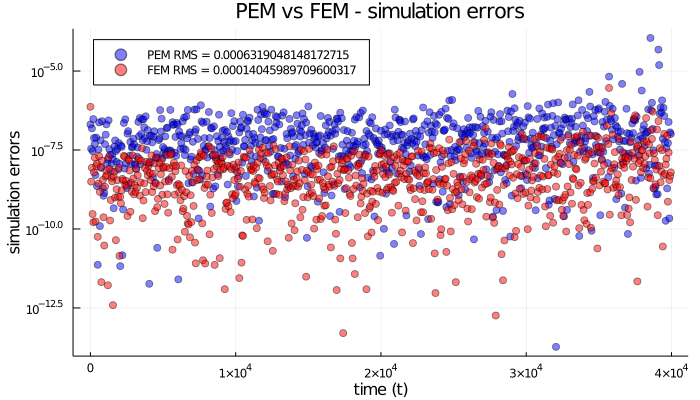

In [42]:
# Comparing simulation errors between PEM and FEM
p19 = scatter(1:n:T_val, 
              sq_sim_error_PEM[1:n:T_val], 
              color="blue", 
              alpha=0.5,
              markersize=4, 
              size=(700,400), 
              yscale=:log10,
              xlabel="time (t)", 
              ylabel="simulation errors",
              label="PEM RMS = "*string(sqrt(mean(sq_sim_error_PEM))),
              legend=:topleft)
scatter!(1:n:T_val, 
         sq_sim_error_FEM[1:n:T_val], 
         color="red", 
         alpha=0.5,
         markersize=4,
         labels="FEM RMS = "*string(sqrt(mean(sq_sim_error_FEM))),
         title="PEM vs FEM - simulation errors")

In [43]:
savefig(p19, "figures/PEMvFEM_NARMAXpol3_sim-error.png")